# 4:2 MENT — random uncoupled phase advances

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj2D_Contour
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian-mixture"
ndim = 4
nmeas = 10
xmax = 3.5
seed = 12345
nbins = 50

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

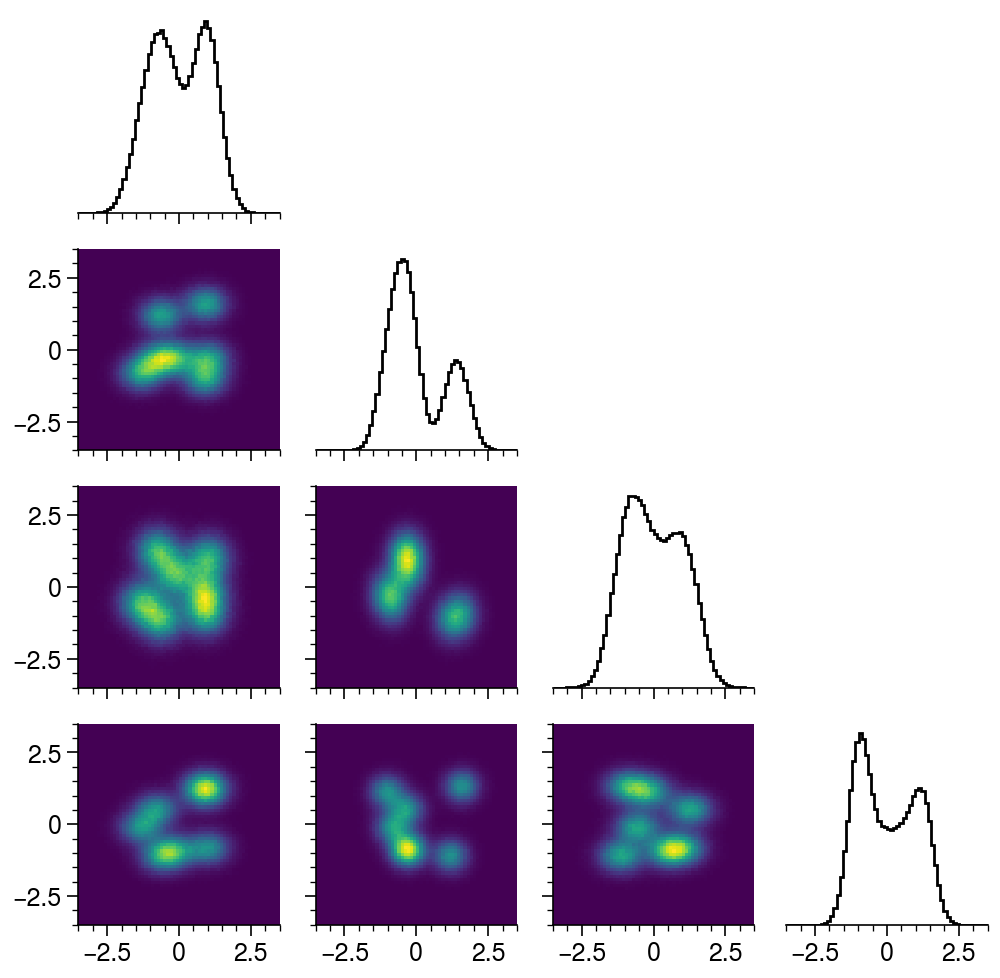

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
blur = 0.0
kde = False
kde_bandwidth_frac = 1.0
axis_meas = (0, 2)

Create phase space transformations.

In [7]:
rng = np.random.default_rng(seed)
phase_advances = rng.uniform(0.0, np.pi, size=(nmeas, 2))
transfer_matrices = []
for mux, muy in phase_advances:
    matrix = np.eye(ndim)
    matrix[0:2, 0:2] = ment.sim.rotation_matrix(mux)
    matrix[2:4, 2:4] = ment.sim.rotation_matrix(muy)
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

Create histogram diagnostics.

In [8]:
axis_proj = axis_meas
bin_edges = 2 * [np.linspace(-xmax, xmax, nbins + 1)]

diagnostics = []
for transform in transforms:
    diagnostic = ment.diag.HistogramND(
        axis=axis_meas,
        edges=bin_edges,
        kde=kde,
        kde_bandwidth_frac=kde_bandwidth_frac,
        blur=blur,
        thresh=0.0,
        thresh_type="abs",
    )
    diagnostics.append([diagnostic])

Generate data from the source distribution.

In [9]:
projections = ment.simulate_with_diag_update(
    x_true,
    transforms,
    diagnostics,
    kde=False,
    blur=False,
    thresh=5.00e-03,
)

In [10]:
# @interact(index=(0, nmeas - 1))
# def update(index: int):
#     coords = unravel(projections)[index].coords
#     values = unravel(projections)[index].values

#     fig, ax = plt.subplots()
#     ax.pcolormesh(coords[0], coords[1], values.T, colorbar=True,)

## Reconstruction model

In [11]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

samp_grid_res = 33
samp_noise = 0.0
samp_grid_shape = ndim * [samp_grid_res]
samp_grid_limits = limits

sampler = ment.GridSampler(
    grid_limits=samp_grid_limits,
    grid_shape=samp_grid_shape,
    noise=samp_noise,
)

integration_limits = [limits[axis] for axis in range(ndim) if axis not in axis_proj]
integration_limits = [[integration_limits]] * len(transforms)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=200_000,
    integration_limits=integration_limits,
    integration_size=(15**4),
    mode="sample",  # {"sample", "integrate"}
    verbose=0,
)

## Train

In [12]:
plot_nsamp = x_true.shape[0]

In [13]:
def plot_model(model):
    figs = []

    # Sample particles
    x_pred = model.sample(plot_nsamp)

    # Plot reconstructed vs. true distribution
    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot_points(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        process_kws=dict(blur=0.0),
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Simulate measurements
    projections_true = ment.sim.copy_histograms(model.projections)
    projections_pred = ment.sim.copy_histograms(model.diagnostics)
    projections_pred = ment.sim.simulate_with_diag_update(
        x_pred, transforms, projections_pred, kde=False, blur=False
    )

    projections_true = unravel(projections_true)
    projections_pred = unravel(projections_pred)

    # Plot simulated vs. measured projections.
    contour_levels = np.linspace(0.01, 1.0, 7)
    contour_colors = ["black", "red"]
    plot_kws = dict(
        process_kws=dict(blur=1.0, scale="max"),
        kind="contour",
        levels=contour_levels,
        lw=0.9,
    )

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figwidth=(1.1 * ncols))
    for proj_true, proj_pred, ax in zip(projections_true, projections_pred, axs):
        psv.plot_hist(proj_true, ax=ax, colors=contour_colors[0], **plot_kws)
        psv.plot_hist(proj_pred, ax=ax, colors=contour_colors[1], **plot_kws)
    figs.append(fig)

    return figs

non numeric history values being saved


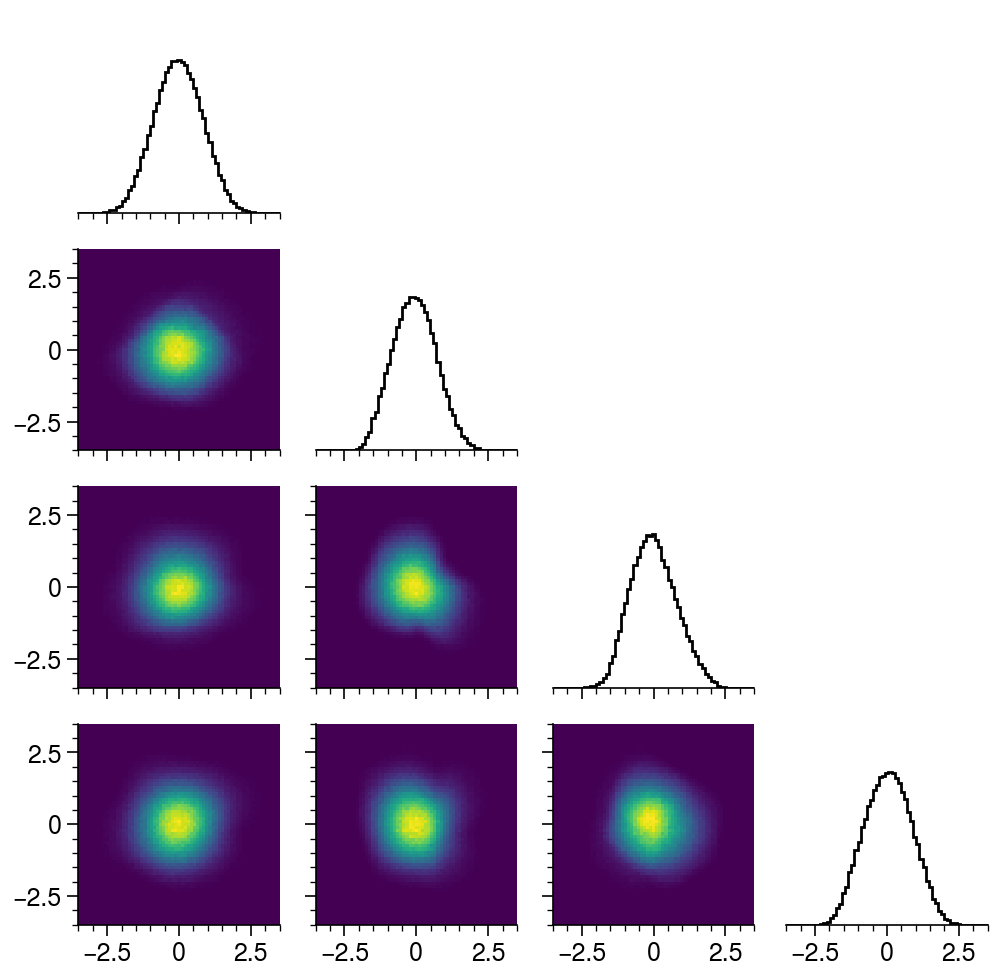

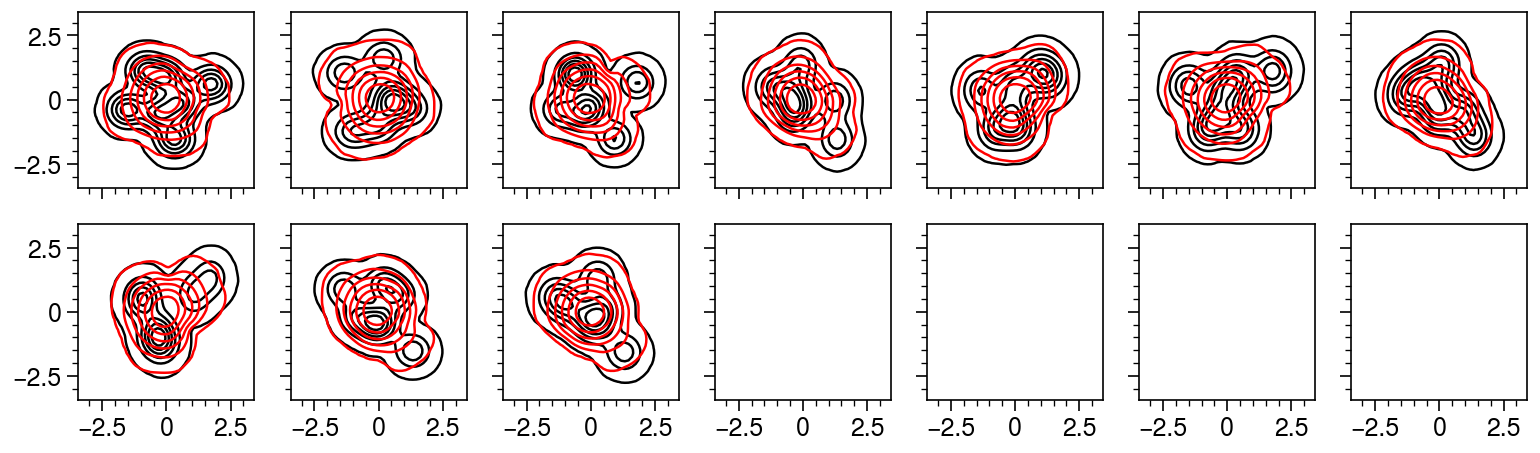

{'mean_abs_error': np.float64(0.01173602854540234)}
epoch = 1


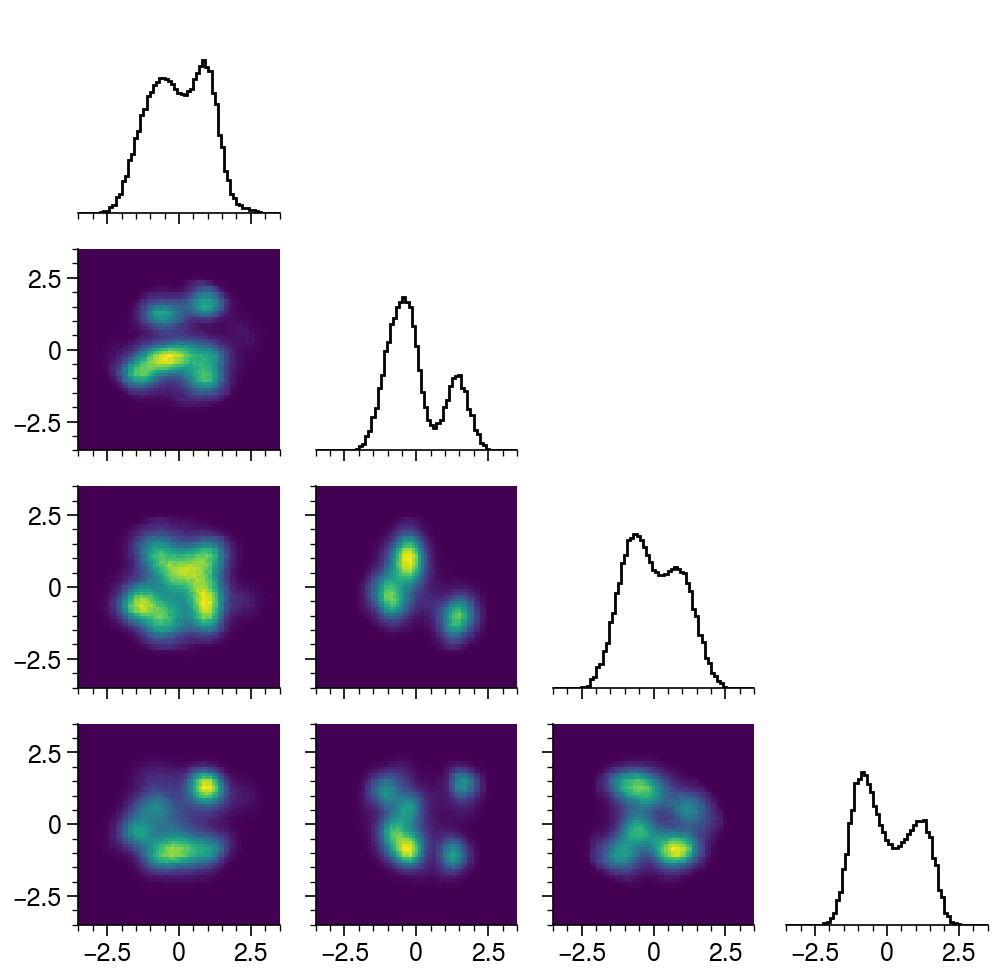

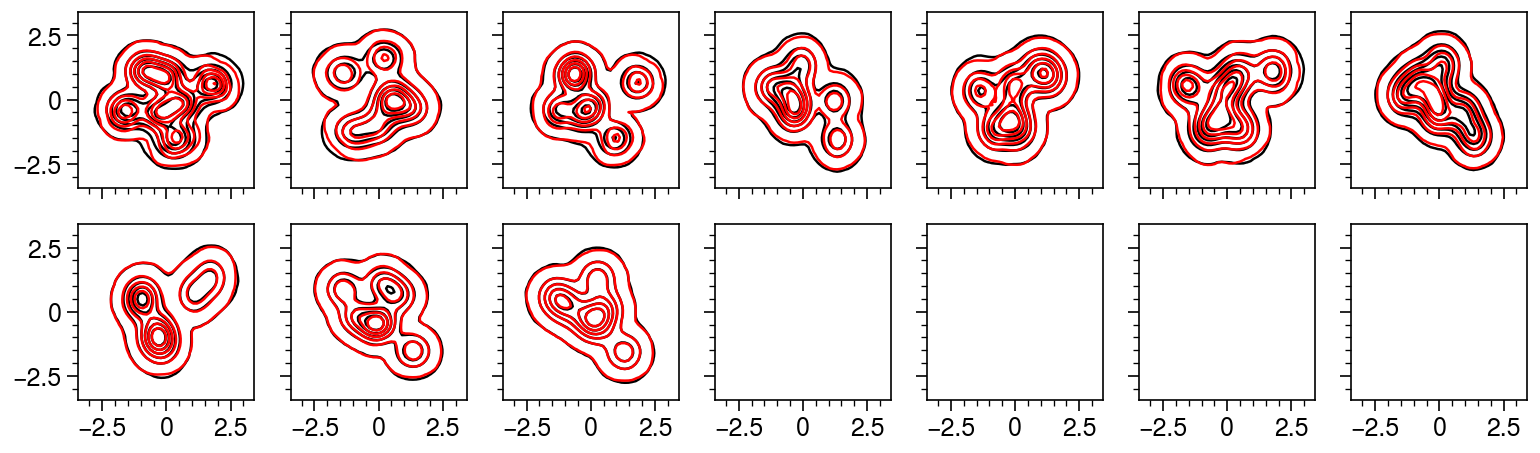

{'mean_abs_error': np.float64(0.0023492421933552768)}
epoch = 2


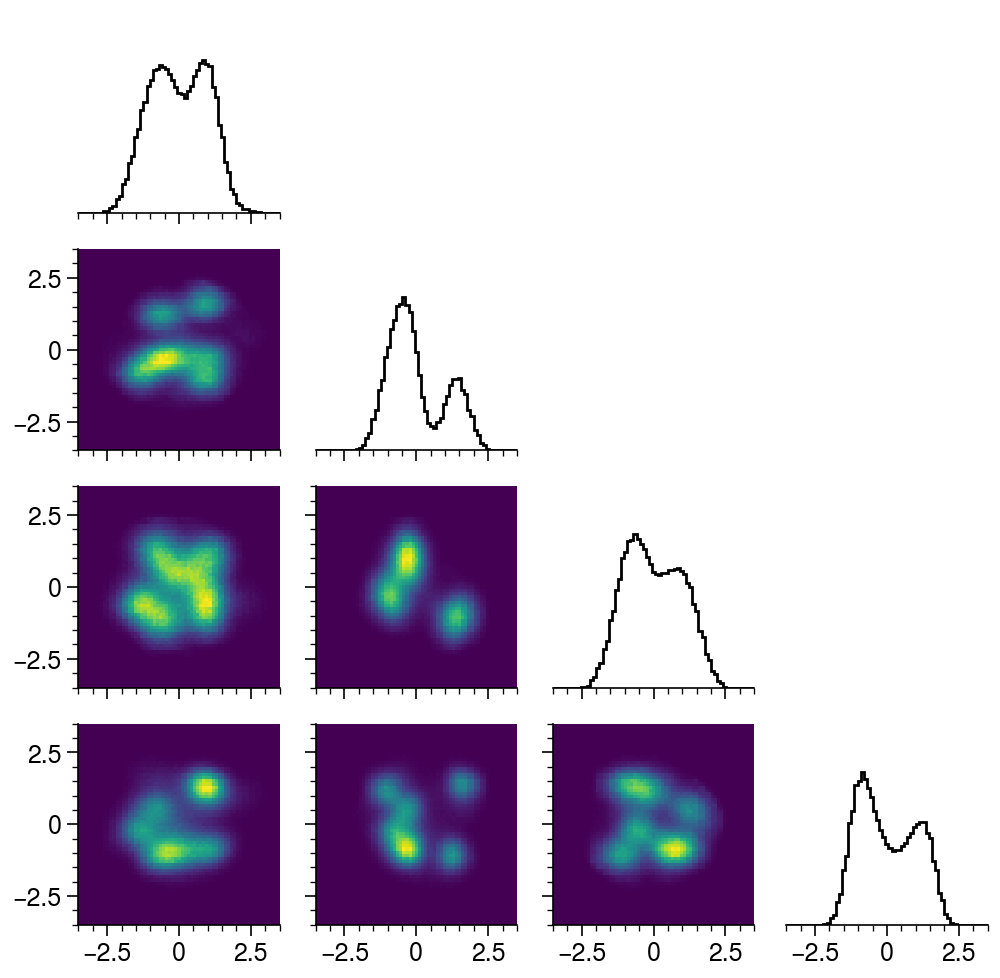

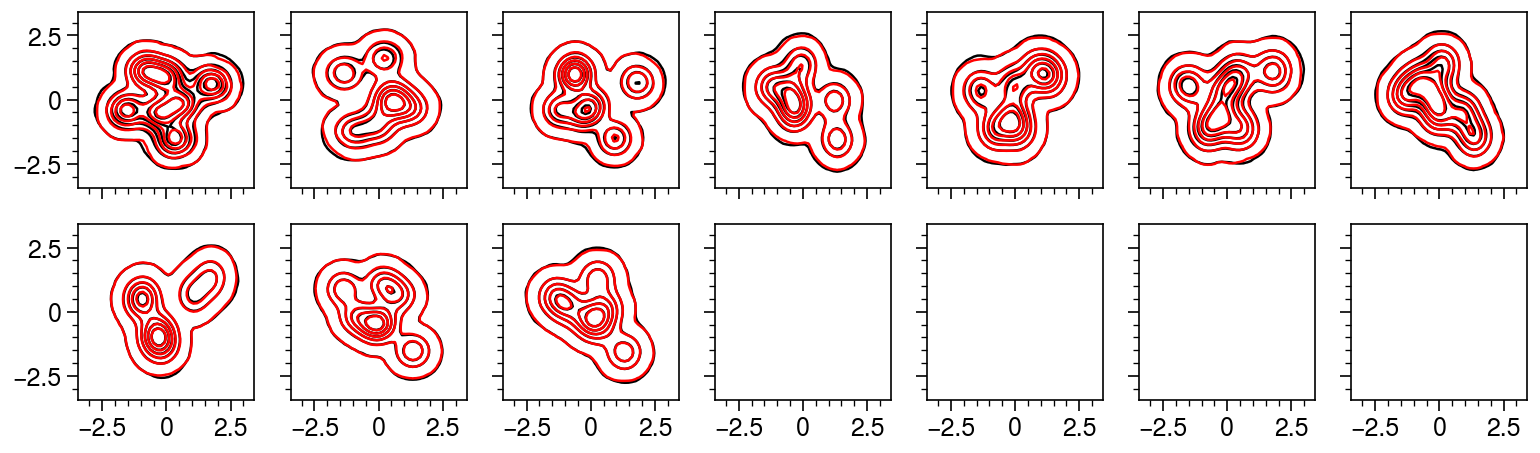

{'mean_abs_error': np.float64(0.0017341082674240424)}
epoch = 3


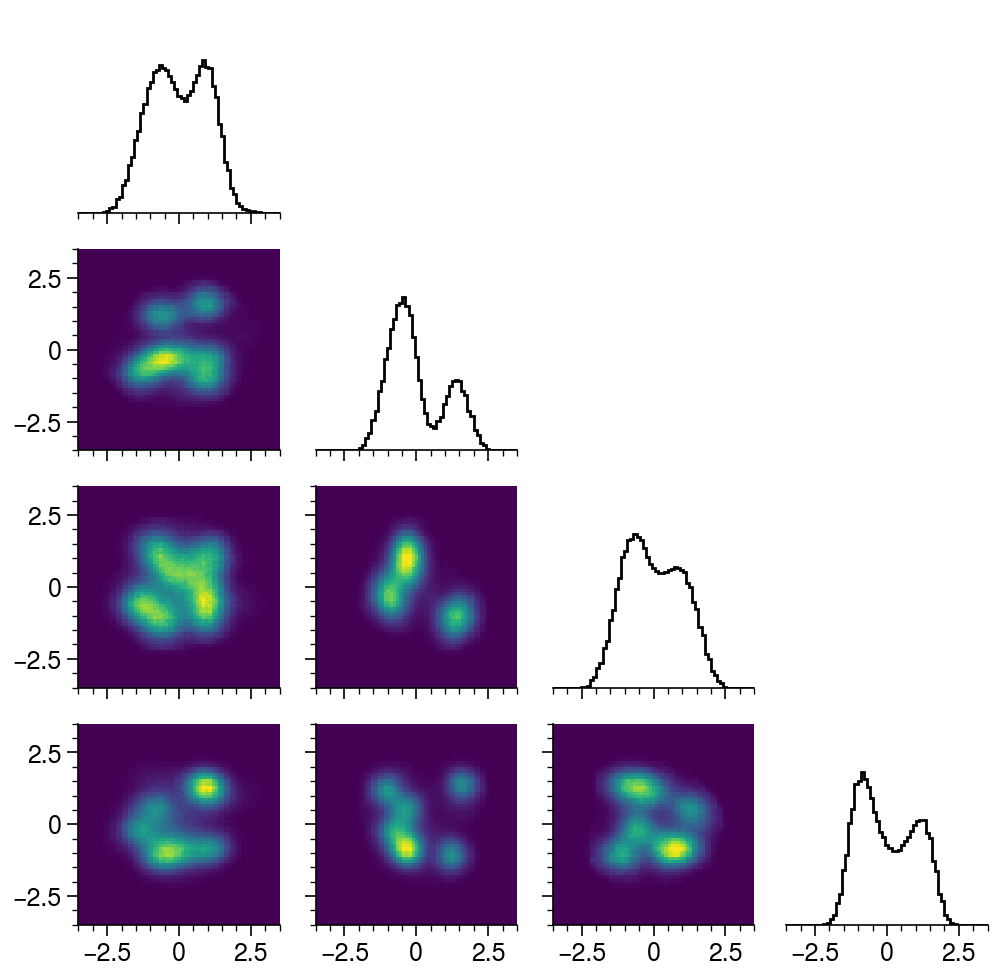

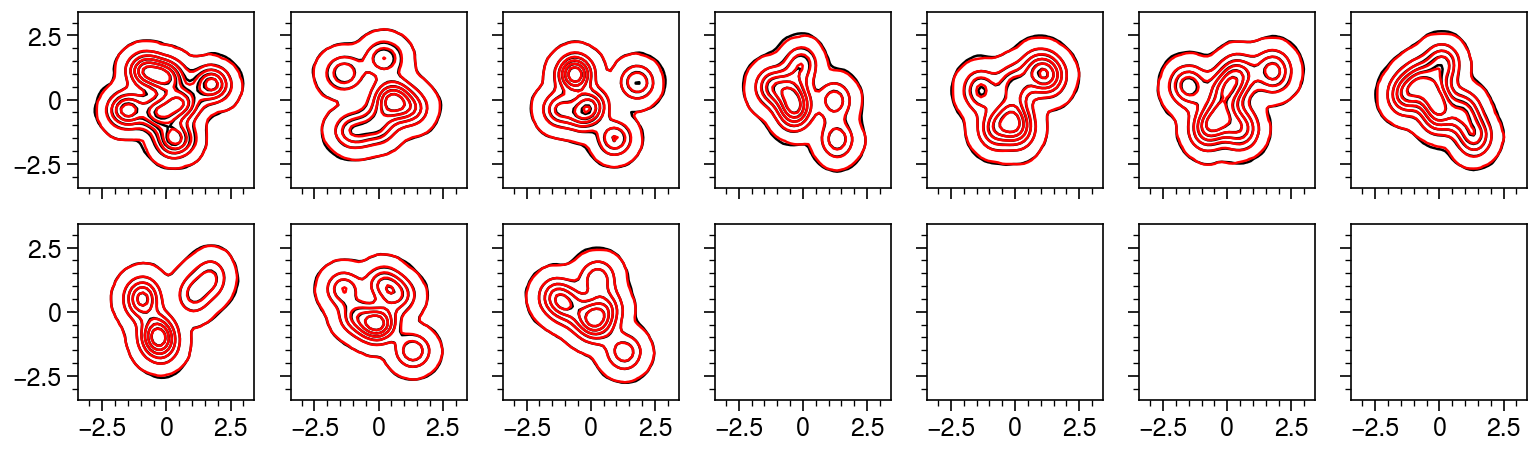

{'mean_abs_error': np.float64(0.0015941219838746118)}


In [14]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=ment.train.Evaluator(n_samples=100_000),
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.90)

## Evaluate

In [15]:
x_pred = model.unnormalize(model.sample(1_000_000))

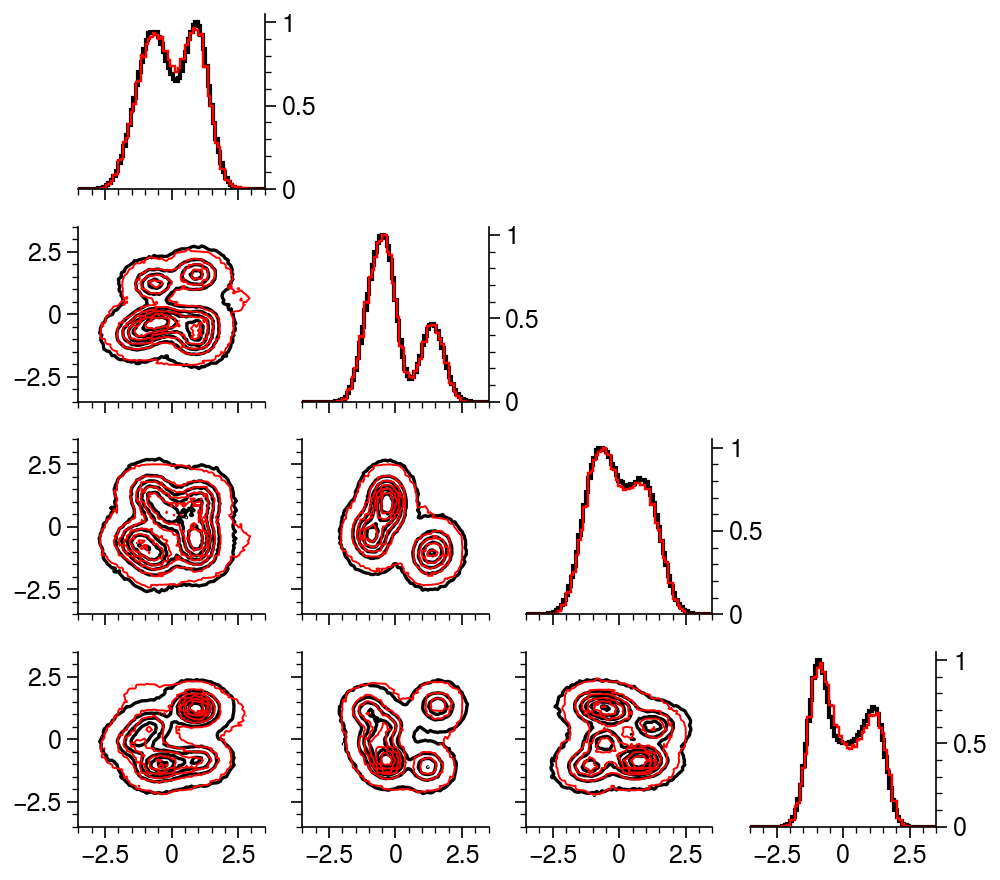

In [16]:
grid = psv.CornerGrid(ndim, figheight=(ndim * 1.10), figwidth=(ndim * 1.25), diag_rspine=True, space=1.5)
for i, x in enumerate([x_true, x_pred]):
    color = ["black", "red"][i]
    lw = [1.2, 0.7][i]
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color, lw=(lw * 1.25)),
        kind="contour",
        process_kws=dict(blur=0.0, scale="max"),
        mask=False,
        levels=np.linspace(0.01, 1.0, 7),
        color=color,
        lw=lw,
    )
plt.show()

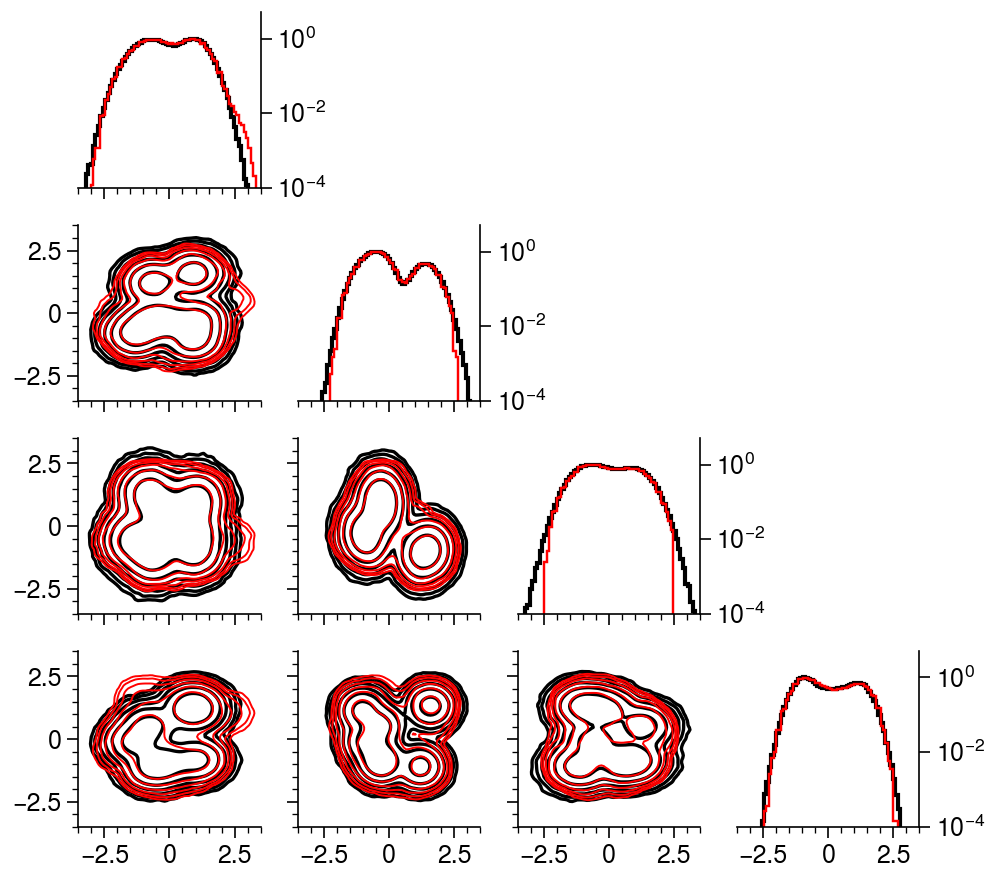

In [17]:
grid = psv.CornerGrid(ndim, figheight=(ndim * 1.10), figwidth=(ndim * 1.25), diag_rspine=True, space=1.5)
for i, x in enumerate([x_true, x_pred]):
    color = ["black", "red"][i]
    lw = [1.2, 0.7][i]
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color, lw=(lw * 1.25)),
        kind="contour",
        process_kws=dict(blur=1.0, scale="max"),
        mask=False,
        levels=(10.0 ** np.linspace(-3.0, 0.0, 7)),
        color=color,
        lw=lw,
    )
    grid.format_diag(yscale="log", yformatter="log", ymax=5.0, ymin=0.0001)
plt.show()